In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv
import io
import os
import librosa
import scipy as sc

In [3]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = sc.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform

def load_data(path_to_dataset, sample_rate, num_segments, num_samples_per_segment):
    x_raw = []
    y_raw = []
    names = os.listdir(dataset_path)
    labels = {names[i]: i for i in range(len(names))}
    for label in os.listdir(dataset_path):
        for f in os.listdir(dataset_path+"/"+label):
            signal, sr = librosa.load(dataset_path+"/"+label+"/"+f, sr=None)
            signal = ensure_sample_rate(sr, signal, desired_sample_rate=sample_rate)[1] 
            duration   = librosa.get_duration(y=signal, sr=sr)
            samples_per_track = sr * duration
            if samples_per_track >= num_samples_per_segment :
                step_shift = int(samples_per_track / num_segments)
                for s in range(num_segments):
                    start_sample = step_shift * s 
                    finish_sample = start_sample + num_samples_per_segment 
                    example = signal[start_sample:finish_sample]
                    if len(example) == num_samples_per_segment:
                        x_raw.append( example )
                        y_raw.append( labels[label] )
    return x_raw, y_raw

In [4]:
!gdown --fuzzy 'https://drive.google.com/file/d/1sIj4XguKyaUCSHdJiXM6l3g6wcLx0N9d/view?usp=sharing'
!unzip "/content/audioset.zip"

Downloading...
From: https://drive.google.com/uc?id=1sIj4XguKyaUCSHdJiXM6l3g6wcLx0N9d
To: /content/audioset.zip
100% 489M/489M [00:02<00:00, 236MB/s]
Archive:  /content/audioset.zip
   creating: audioset/
   creating: audioset/background/
  inflating: audioset/background/1-101296-A-19.wav  
  inflating: audioset/background/1-101296-B-19.wav  
  inflating: audioset/background/1-103298-A-9.wav  
  inflating: audioset/background/1-104089-A-22.wav  
  inflating: audioset/background/1-104089-B-22.wav  
  inflating: audioset/background/1-105224-A-22.wav  
  inflating: audioset/background/1-115521-A-19.wav  
  inflating: audioset/background/1-118559-A-17.wav  
  inflating: audioset/background/1-121951-A-8.wav  
  inflating: audioset/background/1-13571-A-46.wav  
  inflating: audioset/background/1-13572-A-46.wav  
  inflating: audioset/background/1-137296-A-16.wav  
  inflating: audioset/background/1-15689-A-4.wav  
  inflating: audioset/background/1-15689-B-4.wav  
  inflating: audioset/backg

In [5]:
SAMPLE_RATE             = 16000
segment_duration        = 1.0
num_samples_per_segment = int(SAMPLE_RATE*segment_duration) 
num_segments            = 10
dataset_path            = "audioset"
x_raw, y_raw            = load_data(dataset_path, 
                                    SAMPLE_RATE, 
                                    num_segments, 
                                    num_samples_per_segment)

In [6]:
#augmentation
import librosa
import numpy as np
import random

def noise_aug(data, noise_factor = 0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def shift_aug(data, shift_max=0.1, shift_direction='both', sampling_rate=SAMPLE_RATE):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift   
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

def pitch_shift_aug(data, pitch_factor_min=-0.2, pitch_factor_max=0.2, sampling_rate=SAMPLE_RATE):
    pitch_factor = random.uniform(pitch_factor_min, pitch_factor_max)*len(data)/SAMPLE_RATE
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def speed_aug(data, min_speed_factor=0.8, max_speed_factor=1.2):
    speed_factor = random.uniform(min_speed_factor, max_speed_factor)
    res = librosa.effects.time_stretch(data, speed_factor)
    if len(res) < len(data):
        res =  np.hstack((data[0:len(data)-len(res)], res)) 
    return res[0:len(data)]

In [7]:
number_of_examples = len(y_raw)
for i in range(number_of_examples): 
    x_raw.append( noise_aug(x_raw[i],) )
    x_raw.append( shift_aug(x_raw[i]) )
    x_raw.append( pitch_shift_aug(x_raw[i]) )
    x_raw.append( speed_aug(x_raw[i]) )
    y_raw.append(y_raw[i])
    y_raw.append(y_raw[i])
    y_raw.append(y_raw[i])
    y_raw.append(y_raw[i])

In [8]:
!wget https://storage.googleapis.com/tfhub-modules/google/yamnet/1.tar.gz
!mkdir saved_model
!tar -xvf /content/1.tar.gz -C /content/saved_model/

loaded_model = tf.saved_model.load('saved_model')

--2022-08-28 22:46:40--  https://storage.googleapis.com/tfhub-modules/google/yamnet/1.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.69.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14237478 (14M) [application/octet-stream]
Saving to: ‘1.tar.gz’

1.tar.gz            100%[===================>]  13.58M  13.4MB/s    in 1.0s    

2022-08-28 22:46:42 (13.4 MB/s) - ‘1.tar.gz’ saved [14237478/14237478]

./
./assets/
./assets/yamnet_class_map.csv
./variables/
./variables/variables.index
./variables/variables.data-00000-of-00001
./saved_model.pb


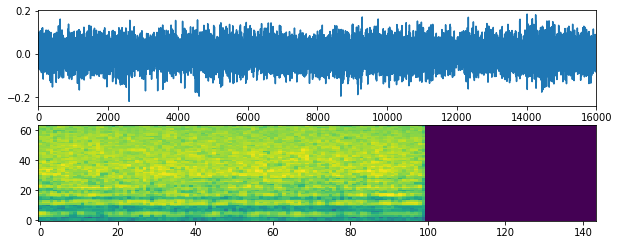

In [9]:
import matplotlib.pyplot as plt
from IPython.display import Audio

waveform = x_raw[500]
scores, embeddings, log_mel_spectrogram = loaded_model(waveform)

plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

scores_np = scores.numpy()
spectrogram_np = log_mel_spectrogram.numpy()
# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

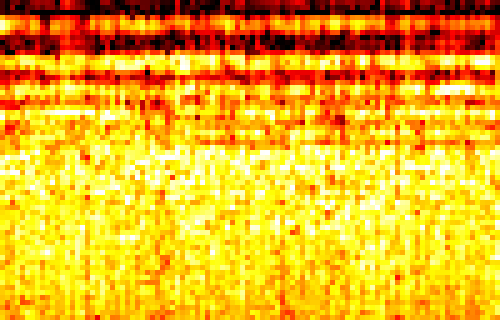

In [20]:
from sklearn.preprocessing import MinMaxScaler
from google.colab.patches import cv2_imshow
import cv2

scaler = MinMaxScaler()
heatmap = scaler.fit_transform(spectrogram_np.T[:,0:100])
heatmap = heatmap*255
heatmap = heatmap.astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) 
heatmap = cv2.resize(heatmap, (heatmap.shape[1]*5, heatmap.shape[0]*5), interpolation = cv2.INTER_AREA)
cv2_imshow(heatmap)

In [21]:
from sklearn.model_selection import train_test_split

x = []
y = []
for i in range(len(x_raw)):
    scores, embeddings, log_mel_spectrogram = loaded_model(x_raw[i])
    x.append( embeddings.numpy() )  
    y.append( y_raw[i] )

x_np = np.array(x)
x_np = x_np.reshape( (x_np.shape[0], x_np.shape[1]*x_np.shape[2]) )
y_np = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x_np, y_np, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    shuffle=True)

In [51]:
#**************************************************************************
#************************  prototype_layer.py  ****************************
#**************************************************************************
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from scipy.linalg import hadamard
from math import log2, ceil

class HadamardInitializer(tf.keras.initializers.Initializer):

    def __init__(self, ):
        pass

    def __call__(self, shape, dtype=None):
        init_matrix = hadamard(pow(2, ceil(log2(shape[1]))))
        init_matrix[init_matrix<0]=0
        init_matrix = init_matrix.astype(np.float32)
        init_matrix[init_matrix==0]=0.2
        init_matrix[init_matrix==1]=0.8
        init_matrix = init_matrix[0:shape[0], 0:shape[1]]
        init_matrix = tf.Variable(init_matrix)
        return init_matrix

    def get_config(self):  # To support serialization
        return {}

class PlotkinBoundInitializer(tf.keras.initializers.Initializer):

    def __init__(self, class_num):
        self.class_num = class_num
        # container radius as half of Plotkin’s Bound
        self.r = 0.25 * class_num / (class_num-1) 

    def __call__(self, shape, dtype=None):
        vector = np.ones((self.class_num,))*self.r
        init_vector = tf.Variable(vector, dtype=tf.float32)
        return init_vector

    def get_config(self):  # To support serialization
        return {}
        
class InformationExtremeLoss(tf.keras.layers.Layer):
  
    def __init__(self, num_classes=2, dim_hidden=1, lambda_c=1.0, **kwargs):
        super().__init__(**kwargs)
        self.dim_hidden  = dim_hidden
        self.num_classes = num_classes
        self.lambda_c    = tf.constant( lambda_c, dtype=tf.float32 )       
        self.epsilon     = tf.constant( 1e-6, dtype=tf.float32 )
        self.one         = tf.constant( 1.0, dtype=tf.float32 )
        self.dim         = tf.constant( self.dim_hidden, dtype=tf.float32 )
        self.dn          = tf.constant( (self.num_classes-1)*(self.num_classes-1)*self.dim_hidden, dtype=tf.float32 )

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.num_classes, self.dim_hidden),
                                       initializer = HadamardInitializer(), #tf.keras.initializers.RandomUniform(minval=0., maxval=1.),
                                       trainable=True)   
        self.radiuses = self.add_weight(name='radiuses',
                                       shape=(self.num_classes,),
                                       initializer = PlotkinBoundInitializer(self.num_classes), #tf.keras.initializers.RandomUniform(minval=0., maxval=1.), 
                                       trainable=True)   
        super().build(input_shape)

    def call(self, inputs, mask=None):
        embedding, labels   = inputs[0], inputs[1]
        labels_int          = tf.math.argmax(labels, axis=1) 
        batch_size          = embedding.shape[0]
        if batch_size is None:
            batch_size = 1
        expanded_centers    = tf.expand_dims(self.centers, axis=0)   
        expanded_centers    = tf.repeat( expanded_centers, repeats=[batch_size], axis=0 )        
        expanded_embedding  = tf.expand_dims( embedding, axis=1 )
        expanded_embedding  = tf.repeat( expanded_embedding, repeats=[self.num_classes], axis=1 ) 
        distance_centers    = tf.math.squared_difference( expanded_embedding, expanded_centers )
        distance_centers    = tf.math.reduce_sum( distance_centers, axis=2 )

        # Labels and Distance-based membership function
        y           = tf.cast(labels, tf.float32) #* 0.8 + 0.1 # label smoothing
        u           = self.one-distance_centers /(self.dim*self.radiuses+self.epsilon) #tf.pow(( ), 2)
        u           = tf.nn.relu(u)
        temperature = 1
        y_hat       = tf.nn.softmax(u/temperature)
        #y_hat   = tf.keras.activations.hard_sigmoid(6*u) #tf.nn.relu(u) #t # # tf.math.maximum(u, 0) # tf.math.sigmoid(u*6)  

        # Smoothed versions of statistical test results 
        tp      = tf.reduce_sum(y_hat * y, axis=0)
        tn      = tf.reduce_sum((self.one - y_hat) * (self.one - y), axis=0)
        fp      = tf.reduce_sum(y_hat * (self.one - y), axis=0)
        fn      = tf.reduce_sum((self.one - y_hat) * y, axis=0)
        
        # Macro F1
        #soft_f1 = 2*tp / (2*tp + fn + fp + self.epsilon)
        #cost    = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
        #loss1   = tf.reduce_mean(cost)

        # Macro Information Criterion
        D1        = tp/(tp + fn + self.epsilon) + self.epsilon # sensitivity
        D2        = tn/(tn + fp + self.epsilon) + self.epsilon # specificity
        alpha     = fn/(fn + tp + self.epsilon) + self.epsilon # miss rate
        betta     = fp/(fp + tn + self.epsilon) + self.epsilon # fall-out rate
        
        D1        = tf.math.maximum(D1, 0.5)     # move to admissible domain  D1   >= 0.5
        D2        = tf.math.maximum(D2, 0.5)     # move to admissible domain  D2   >= 0.5
        alpha     = tf.math.minimum(alpha, 0.5)  # move to admissible domain  alpha < 0.5
        betta     = tf.math.minimum(betta, 0.5)  # move to admissible domain  betta < 0.5
        
        c1        = alpha/(alpha+D2)
        c2        = betta/(betta+D1)
        c3        = D1/(D1+betta)
        c4        = D2/(D2+alpha)

        shannon   =  c1*tf.math.log(c1 + self.epsilon ) 
        shannon   += c2*tf.math.log(c2 + self.epsilon )
        shannon   += c3*tf.math.log(c3 + self.epsilon )
        shannon   += c4*tf.math.log(c4 + self.epsilon )
        shannon   = self.one + 0.5*shannon/tf.math.log(tf.cast(2, tf.float32))
        loss1     = tf.reduce_mean(self.one - shannon)

        # Geometric regularization - Contrastive Center 
        distances_intra     = tf.gather( distance_centers, indices=tf.expand_dims(labels_int, axis=1), batch_dims=1 )
        distances_sum       = tf.math.reduce_sum( distance_centers, axis=1 )
        distances_sum       = tf.expand_dims( distances_sum, axis=0 )
        distances_sum       = tf.transpose( distances_sum )
        distance_inter      = distances_sum - distances_intra
        loss2               = (distances_intra)/( distance_inter + self.epsilon) #self.lambda_c )

        # Geometric regularization - MiniMax
        repeat_centers           = tf.expand_dims( self.centers, axis=1 )
        repeat_centers           = tf.repeat( repeat_centers, repeats=[self.num_classes], axis=1 ) 
        distance_inter_centers   = tf.math.squared_difference( self.centers, repeat_centers )
        distance_inter_centers   = tf.math.reduce_sum( distance_inter_centers, axis=2 ) / self.dn
        mean_norm_inter_centers  = tf.reduce_sum( distance_inter_centers ) + self.epsilon
        mean_normilized_radiuses = tf.reduce_mean(self.radiuses)
        loss3                    = mean_normilized_radiuses / ( mean_norm_inter_centers + self.epsilon )

        # Information Bootleneck (Compression) - Feature discretization   
        e                   = tf.ones([batch_size, self.dim_hidden] )
        dif                 = tf.linalg.matmul(embedding, e-embedding, transpose_b=True)
        loss4               = tf.linalg.tensor_diag_part(dif)
        loss4               = tf.expand_dims(loss4, axis=0)  
        loss4               = tf.transpose(loss4)

        # Information Bootleneck (Compression) - Prototype discretization 
        ec                  = tf.ones([self.num_classes, self.dim_hidden] )
        difc                = tf.linalg.matmul(self.centers, ec-self.centers, transpose_b=True)
        loss5               = tf.linalg.tensor_diag_part(difc)
        loss5               = tf.math.reduce_sum( loss5, axis=0 )

        # Final loss
        return 1.0*loss1 + 1.0*loss2 + 0.001*loss4 + 0.0001*loss5 + 0.0001*loss3

    def compute_output_shape(self, input_shape):
        return tf.compat.v1.keras.backend.int_shape(self.loss)

### custom loss
def zero_loss(y_true, y_pred):
    return tf.math.reduce_sum(y_pred, axis=0)

In [97]:
nn_classes    = len(np.unique(y_test))
input_length  = x_test[0].shape[0]
embedding_dim = 24

def create_model(x, labels):
    x = layers.Dense(embedding_dim, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(embedding_dim, activation=tf.keras.activations.hard_sigmoid, name='main_out')(x)
    side = layers.Dense(nn_classes, activation='softmax', name='side_out')(x) 
    main = InformationExtremeLoss(num_classes=nn_classes, dim_hidden=embedding_dim, name='BinarizedPrototype')([x, labels])
    return side, main

In [99]:
main_input = tf.keras.layers.Input(shape=(input_length,), name='input1')   
aux_input = tf.keras.layers.Input((nn_classes,), name='input2')

final_output, side_output = create_model(main_input, aux_input)

model = tf.keras.models.Model(inputs=[main_input, aux_input], outputs=[final_output, side_output])

optim = tf.keras.optimizers.Adam(learning_rate=0.0006)

model.compile(optimizer=optim,
              loss=[tf.keras.losses.CategoricalCrossentropy(), zero_loss],
              loss_weights=[0.05, 0.95],
              metrics=["acc"])

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 2048)]       0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 24)           49176       ['input1[0][0]']                 
                                                                                                  
 dropout_5 (Dropout)            (None, 24)           0           ['dense_5[0][0]']                
                                                                                                  
 main_out (Dense)               (None, 24)           600         ['dropout_5[0][0]']              
                                                                                           

In [100]:
y_train_onehot = tf.keras.utils.to_categorical(y_train, nn_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, nn_classes)

dummy1 = np.zeros((x_train.shape[0], 1))
dummy2 = np.zeros((x_test.shape[0], 1))

In [103]:
history=model.fit([x_train, y_train_onehot], 
                  [y_train_onehot, dummy1], 
                  batch_size=64,
                  epochs=100,
                  verbose=1,
                  validation_data=([x_test, y_test_onehot], [y_test_onehot, dummy2]))

Epoch 1/100
284/284 [==============================] - 3s 10ms/step - loss: 56.0778 - side_out_loss: 0.1139 - BinarizedPrototype_loss: 59.0233 - side_out_acc: 0.9700 - BinarizedPrototype_acc: 0.0000e+00 - val_loss: 56.5029 - val_side_out_loss: 0.1524 - val_BinarizedPrototype_loss: 59.4688 - val_side_out_acc: 0.9562 - val_BinarizedPrototype_acc: 0.0000e+00
Epoch 2/100
284/284 [==============================] - 3s 9ms/step - loss: 56.0303 - side_out_loss: 0.1120 - BinarizedPrototype_loss: 58.9733 - side_out_acc: 0.9708 - BinarizedPrototype_acc: 0.0000e+00 - val_loss: 56.5321 - val_side_out_loss: 0.1535 - val_BinarizedPrototype_loss: 59.4994 - val_side_out_acc: 0.9570 - val_BinarizedPrototype_acc: 0.0000e+00
Epoch 3/100
284/284 [==============================] - 3s 9ms/step - loss: 55.9535 - side_out_loss: 0.1111 - BinarizedPrototype_loss: 58.8926 - side_out_acc: 0.9727 - BinarizedPrototype_acc: 0.0000e+00 - val_loss: 56.4807 - val_side_out_loss: 0.1507 - val_BinarizedPrototype_loss: 59.4

In [104]:
#**************************************************************************
#************************ SAVE_FEATURE_EXTRACTOR **************************
#**************************************************************************

import matplotlib.pyplot as plt
import numpy as np

feature_extractor = tf.keras.Model(inputs=model.input[0], 
                                   outputs=model.get_layer('main_out').output)

feature_extractor.save('highlevel_feature_extractor.h5')

In [105]:
# result path
path_to_feature_extractor = 'highlevel_feature_extractor.h5'
path_to_prototypes        = 'prototypes.csv'
path_to_radiuses          = 'radiuses.csv'

In [106]:
#**************************************************************************
#************************  SAVE_PROTOTYPES ********************************
#**************************************************************************
from numpy import savetxt

prototypes = model.get_layer('BinarizedPrototype').get_weights()[0]

prototypes[prototypes>0.5] = 1
prototypes[prototypes<=0.5] = 0

# save to csv file
savetxt(path_to_prototypes, prototypes, delimiter=',')

In [107]:
# view inter-center distances
def inter_dist(prot):
    dist_list = []
    for i in range(len(prot)) :
        for j in range(len(prot)) :
            if i != j :
                dist = ((prot[i] - prot[j])**2).sum(axis=0)
                dist_list.append( dist )
                #print( dist )
    print("min dist : ", min(dist_list))
    print("max dist : ", max(dist_list))
    print("mean dist : ", sum(dist_list) / len(dist_list))          

inter_dist(prototypes)

min dist :  9.0
max dist :  17.0
mean dist :  12.0


In [108]:
radiuses = model.get_layer('BinarizedPrototype').get_weights()[1]
radiuses = np.round(radiuses*embedding_dim)
savetxt(path_to_radiuses, radiuses, delimiter=',')
radiuses

array([7., 5., 4.], dtype=float32)

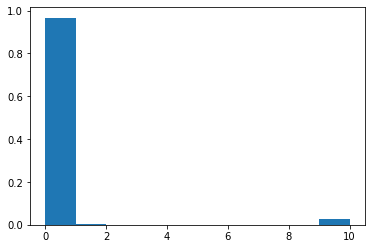

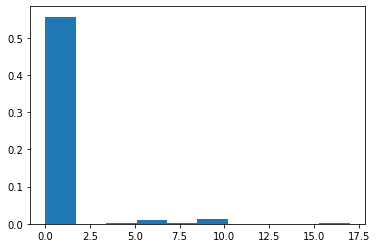

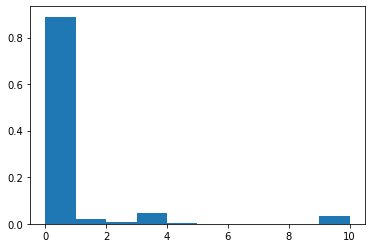

In [109]:
#**************************************************************************
#******************* SHOW DISTANCE DISTRIBUTION BETWEEN ******************* 
#************** FEATURE VECTOR AND CORRESPONDING PROTOTYPE ****************
#**************************************************************************

import matplotlib.pyplot as plt
import numpy as np

feature_extractor = tf.keras.Model(inputs=model.input[0], outputs=model.get_layer('main_out').output)

feats = feature_extractor.predict(x_test)

feats[feats >  0.5] = 1
feats[feats <= 0.5] = 0

count = {i:[] for i in range(nn_classes)}
for i in range(len(feats)):
    x = feats[i]
    y = y_test[i]
    c = prototypes[int(y)]
    count[int(y)].append( ((x - c)**2).sum(axis=0) )

for k in range(nn_classes):
    h = sorted(np.array(count[k]))
    plt.hist(h, density=True)
    plt.show()

In [110]:
#**************************************************************************
#***** TUNE THE DECISION BOUNDARIES OF INFORMATION-EXTREME CLASSIFIER *****
#**************************************************************************
import math

class InformationExtremeСlassifier:

    def __init__(self, etalons=None, radiuses=None):
        self.etalons   = None
        self.radiuses  = None
        if etalons is not None :
            self.etalons  = etalons
            self.class_num   = len(etalons)
            self.feature_num = len(etalons[0])
        if radiuses is not None :
            self.radiuses = radiuses

    def compute_etalons(self, X_train, y_train):
        self.class_num = len( np.unique(y_train) )
        self.feature_num = len(X_train[0])
        self.counter = { i: 0 for i in range(self.class_num)}
        self.etalons = np.zeros((self.class_num, self.feature_num))
        self.center = np.zeros(self.feature_num)
        self.n = len(X_train)
        for i in range(self.n):
            x = X_train[i]
            class_id = y_train[i]
            self.etalons[class_id] = self.etalons[class_id] + x
            self.center = self.center + x
            self.counter[class_id] = self.counter[class_id] + 1
        self.center = self.center / self.n
        for c in range(self.class_num):
            corrected_counter = max(self.counter[c], 1)
            self.etalons[c] = self.etalons[c] / corrected_counter
            self.etalons[c] = self.etalons[c] - self.center[c] 
            self.etalons[c][ self.etalons[c]  > 0 ] = 1
            self.etalons[c][ self.etalons[c] <= 0 ] = 0
        return self.etalons

    def compute_max_radiuses(self, ):
        self.max_radius = np.ones(self.class_num)*self.feature_num
        for c in range(self.class_num):
            for k in range(self.class_num):
                distance = self.get_distance(self.etalons[c], self.etalons[k])
                if c != k :
                    if distance < self.max_radius[c] :
                        self.max_radius[c] = distance
        print("self.max_radius = ", self.max_radius)

    def criterion(self, fpr, fnr, sen, spe):
        com1 = com2 = com3 = com4 = 0
        if fpr+spe > 0 :
            com1 = fpr/(fpr+spe)
            com1 = com1*math.log2(com1) if com1>0 else 0
            com2 = spe/(fpr+spe)
            com2 = com2*math.log2(com2) if com2>0 else 0
        if fnr+sen > 0 :
            com3 = fnr/(fnr+sen)
            com3 = com3*math.log2(com3) if com3>0 else 0
            com4 = sen/(sen+fnr)
            com4 = com4*math.log2(com4) if com4>0 else 0
        return 1 + 0.5*(com1+com2+com3+com4)

    def get_distance(self, b1, b2):
        return np.count_nonzero(b1!=b2)

    def compute_distance_matrix(self, X_train):
        self.n = len(X_train)
        self.counter = { i: 0 for i in range(self.class_num)}
        for i in range(self.n):
            class_id = y_train[i]
            self.counter[class_id] = self.counter[class_id] + 1

        self.dist_matrix = np.zeros((self.class_num, self.n))
        for i in range(self.n):
            x = X_train[i]
            for c in range(self.class_num):
                e = self.etalons[c]
                self.dist_matrix[c][i] = self.get_distance(x, e)

    def compute_efficiency(self, y_train):
        for c in range(self.class_num):
            с2с = np.sort(self.dist_matrix[c][y_train==c])
            с2n = np.sort(self.dist_matrix[c][y_train!=c])
            nn = min(self.counter[c], len(с2n))
            с2n = с2n[0:nn]
            sen = len(с2с[с2с<self.radiuses[c]])
            fpr = self.counter[c] - sen
            fnr = len(с2n[с2n<self.radiuses[c]])
            spe = self.counter[c] - fnr
            sen = sen/self.counter[c]
            fpr = fpr/self.counter[c]
            fnr = fnr/self.counter[c]
            spe = spe/self.counter[c]
            E = self.criterion(fpr, fnr, sen, spe)

            print( "radius     ["+str(c)+"] : "+ str(self.radiuses[c]) )
            print( "sensitivity["+str(c)+"] : "+ str(sen) )
            print( "specificity["+str(c)+"] : "+ str(spe) )
            print( "criterion  ["+str(c)+"] : "+ str(E) )
            print( "*****************************" )

    def optimize_radiuses(self, X_train, y_train):
        self.n = len(X_train)
        self.radiuses = np.zeros(self.class_num)
        fpr = fnr = sen = spe = 0
        for c in range(self.class_num):
            с2с = np.sort(self.dist_matrix[c][y_train==c])
            с2n = np.sort(self.dist_matrix[c][y_train!=c])
            nn = min(self.counter[c], len(с2n))
            с2n = с2n[0:nn]
            E_max = 0
            for r in range(1, self.feature_num):
                sen = len(с2с[с2с<r])
                fpr = self.counter[c] - sen
                fnr = len(с2n[с2n<r])
                spe = self.counter[c] - fnr
                sen = sen/self.counter[c]
                fpr = fpr/self.counter[c]
                fnr = fnr/self.counter[c]
                spe = spe/self.counter[c]
                E = self.criterion(fpr, fnr, sen, spe)
                if sen > 0.5 and spe > 0.5 and r < self.max_radius[c]:
                     if E > E_max :
                         E_max = E
                         self.radiuses[c] = r
            print( "radius    ["+str(c)+"] : "+ str(self.radiuses[c]) )
            print( "criterion ["+str(c)+"] : "+ str(E_max) )
            print( "*****************************")
  
    def fit(self, X_train, y_train):
        self.n = len(X_train)
        if self.etalons is None :
            self.compute_etalons(X_train, y_train)
        self.compute_max_radiuses()
        self.compute_distance_matrix(X_train)
        if self.radiuses is None :
            self.optimize_radiuses(X_train, y_train)
        else :
            self.compute_distance_matrix(X_train)
            self.compute_efficiency(y_train)
        return self.etalons, self.radiuses

    def predict(self, x_test):
        result = []
        for j in range(len(x_test)):
            u = np.zeros(self.class_num)
            for c in range(self.class_num):
                e = self.etalons[c]
                dist = self.get_distance(x_test[j], e)
                u[c] = 1 - dist/self.radiuses[c]
                #u = np.exp(u)
        #u /= np.sum(u)
        #return u
            result.append( np.argmax(u) )
        result = np.array(result)
        return result

In [112]:
#classifier = InformationExtremeСlassifier(etalons=prototypes, radiuses=radiuses)
classifier = InformationExtremeСlassifier(etalons=prototypes, radiuses=None) 

features = feature_extractor.predict(x_train)

features[features>0.5] = 1
features[features<=0.5] = 0

classifier.fit(features, y_train)

self.max_radius =  [10.  9.  9.]
radius    [0] : 2.0
criterion [0] : 0.9392027273507895
*****************************
radius    [1] : 1.0
criterion [1] : 0.9214785985301389
*****************************
radius    [2] : 7.0
criterion [2] : 0.930598039549964
*****************************


(array([[1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 1., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
         1., 1., 0., 0., 1., 1., 0., 0.]], dtype=float32), array([2., 1., 7.]))

In [113]:
#**************************************************************************
#**************************** SAVE_RADIUSES *******************************
#**************************************************************************
from numpy import savetxt

# save to csv file
savetxt(path_to_radiuses, classifier.radiuses, delimiter=',')

In [114]:
from sklearn.metrics import f1_score

features = feature_extractor.predict(x_test)

features[features>0.5] = 1
features[features<=0.5] = 0

y_pred = classifier.predict(features)

f1_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='micro')

(0.9629536994114668, 0.9630010277492291)

In [115]:
names = os.listdir(dataset_path)
labels = {names[i]: i for i in range(len(names))}
labels_inv = {value:key for key, value in labels.items()}

import json
with open('labels.json', 'w') as f:
   json.dump(labels_inv, f)

In [ ]:
# ****************************************************************************
# ********************* INFERENCE ********************************************
# ****************************************************************************

In [116]:
!wget https://storage.googleapis.com/tfhub-modules/google/yamnet/1.tar.gz
!mkdir yamnet_1
!tar -xf 1.tar.gz -C /content/yamnet_1

--2022-08-29 03:21:52--  https://storage.googleapis.com/tfhub-modules/google/yamnet/1.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14237478 (14M) [application/octet-stream]
Saving to: ‘1.tar.gz.4’

1.tar.gz.4          100%[===================>]  13.58M  --.-KB/s    in 0.07s   

2022-08-29 03:21:52 (203 MB/s) - ‘1.tar.gz.4’ saved [14237478/14237478]

mkdir: cannot create directory ‘yamnet_1’: File exists


In [117]:
import tensorflow as tf

class PrototypeLayer(tf.keras.layers.Layer):
  
    def __init__(self, prototypes=None, radiuses=None, **kwargs):
        super().__init__(**kwargs)
        self.centers     = tf.constant(prototypes, dtype=tf.float32)
        self.radiuses    = tf.constant(radiuses, dtype=tf.float32)
        self.dim         = tf.constant(prototypes.shape[1], dtype=tf.float32)
        self.num_classes = tf.constant(prototypes.shape[0], dtype=tf.float32)
        self.one         = tf.constant(1, dtype=tf.float32)

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, embedding, mask=None):
        batch_size          = embedding.shape[0]
        if batch_size is None:
            batch_size = 1
        expanded_centers    = tf.expand_dims(self.centers, axis=0)   
        expanded_centers    = tf.repeat( expanded_centers, repeats=[batch_size], axis=0 )        
        expanded_embedding  = tf.expand_dims( embedding, axis=1 )
        expanded_embedding  = tf.repeat( expanded_embedding, repeats=[self.num_classes], axis=1 ) 
        distance_to_centers = tf.math.squared_difference( expanded_embedding, expanded_centers )
        distance_to_centers = tf.math.reduce_sum( distance_to_centers, axis=2 )
        self.u              = self.one-(distance_to_centers /self.radiuses)
        self.u              = tf.nn.relu(self.u)
        temperature         = 0.1
        self.u              = tf.nn.softmax(self.u/temperature)
        return self.u

    def compute_output_shape(self, input_shape):
        return tf.compat.v1.keras.backend.int_shape(self.u)
      
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'prototypes': self.centers.numpy(),
            'radiuses': self.radiuses.numpy(),
        })
        return config

def create_base_network(extractor, prototypes, radiuses):
    x = extractor.output
    out = PrototypeLayer(prototypes=prototypes, radiuses=radiuses)(x)
    return tf.keras.models.Model(inputs=extractor.input, outputs=out)

In [118]:
import json 
import tensorflow as tf
import numpy as np

path_to_primary_feature_extractor   = 'yamnet_1'
path_to_highlevel_feature_extractor = 'highlevel_feature_extractor.h5'
path_to_prototypes                  = 'prototypes.csv'
path_to_radiuses                    = 'radiuses.csv'
path_to_labels                      = 'labels.json'

primary_feature_extractor   = tf.saved_model.load(path_to_primary_feature_extractor)
highlevel_feature_extractor = tf.keras.models.load_model(path_to_highlevel_feature_extractor)
labels                      = json.load(open(path_to_labels))
radiuses                    = np.loadtxt(path_to_radiuses, delimiter=',')
prototypes                  = np.loadtxt(path_to_prototypes, delimiter=',')
classifier                  = create_base_network(highlevel_feature_extractor,
                                                  prototypes,
                                                  radiuses)
classifier.save("classifier.h5")
classifier.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 2048)]            0         
                                                                 
 dense_5 (Dense)             (None, 24)                49176     
                                                                 
 dropout_5 (Dropout)         (None, 24)                0         
                                                                 
 main_out (Dense)            (None, 24)                600       
                                                                 
 prototype_layer_3 (Prototyp  (None, 3)                0         
 eLayer)                                                         
                                                                 
Total params: 49,776
Trainable params: 49,776
Non-trainable params: 0
______________________________________________________

In [119]:
index = 1700
x     = x_raw[index] 
y     = y_raw[index]
label = labels[str(y)]
print("label = ", label)

scores, embeddings, log_mel_spectrogram = primary_feature_extractor(x)
feature_vector = embeddings.numpy()
feature_vector = feature_vector.reshape( feature_vector.shape[0]*feature_vector.shape[1])
feature_vector = np.expand_dims(feature_vector, axis=0)
pr             = classifier.predict(feature_vector)[0]
predicted_label = labels[str(np.argmax(pr))]
predicted_prob  = pr[np.argmax(pr)]
print("predicted label = ", predicted_label, " with prob = ", predicted_prob)



label =  helicopter
predicted label =  helicopter  with prob =  0.99990916
